In [ ]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import os
general_path = '/content/drive/MyDrive/Colab_Notebooks/data/'
print(list(os.listdir(f'{general_path}/genres_original/')))

['blues', 'disco', 'jazz', 'rock', 'country', 'reggae', 'pop', 'classical', 'metal', 'hiphop']


In [ ]:
#import file contains the mean and variance for audio files
data = pd.read_csv(f'{general_path}/features_30_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
#visualize possible groups of genres
from sklearn import preprocessing

data = data.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

#### NORMALIZE X ####
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


#### PCA 2 COMPONENTS ####
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_

array([0.2439355 , 0.21781804])

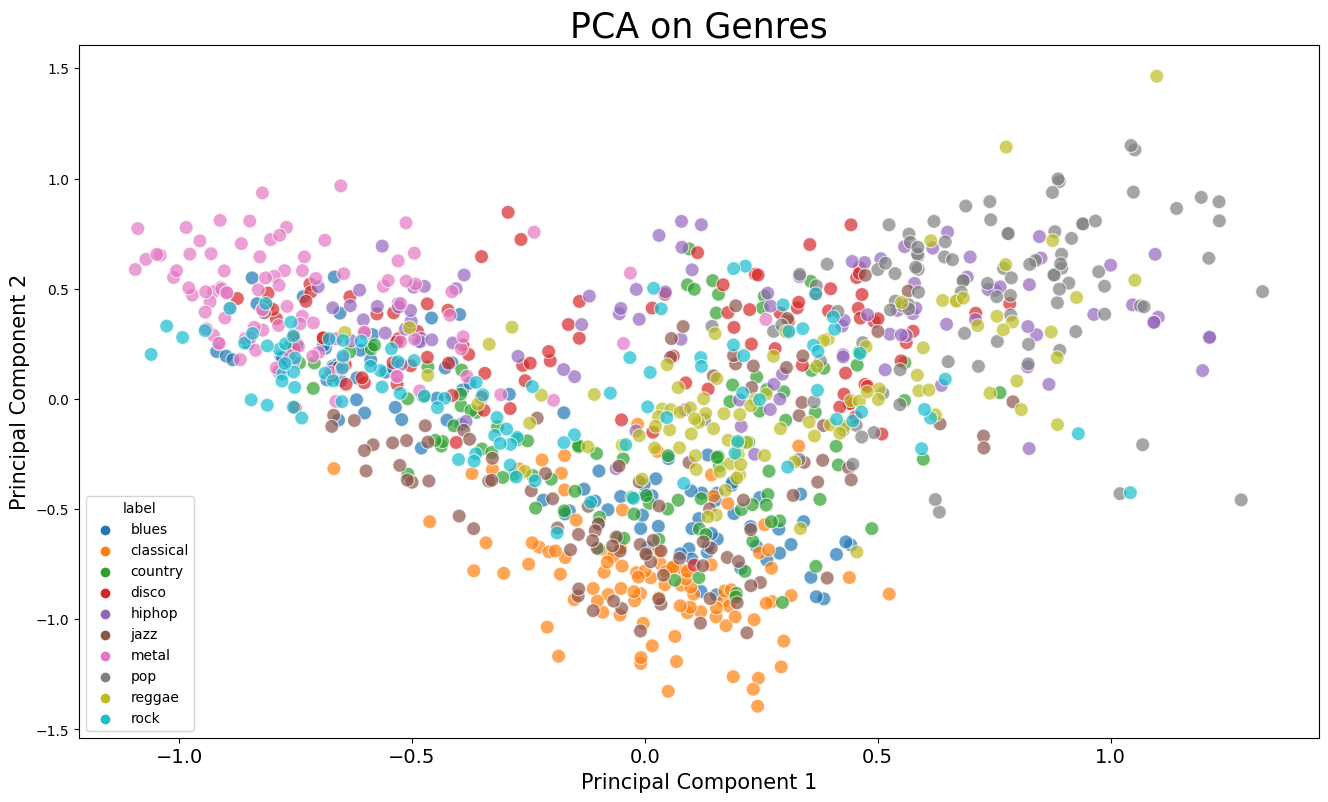

In [ ]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA on Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA Scattert.jpg")

In [ ]:
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [ ]:
#importing file that has precalculated features
data = pd.read_csv(f'{general_path}/features_3_sec.csv')
data = data.iloc[0:, 1:] 
data.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
genre_dict = {0:"hiphop",1:"country",2:"jazz",3:"classical",4:"metal",5:"pop",6:"rock",7:"blues",8:"reggae",9:"disco"}
genre_dict_reverse = {"hiphop":0,"country":1,"jazz":2,"classical":3,"metal":4,"pop":5,"rock":6,"blues":7,"reggae":8,"disco":9}

In [ ]:
y = data['label'].replace(genre_dict_reverse)
X = data.loc[:, data.columns != 'label'] #remove columns with a lable

# Normalize so everything is on the same scale. 
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Accuracy : 0.9009 



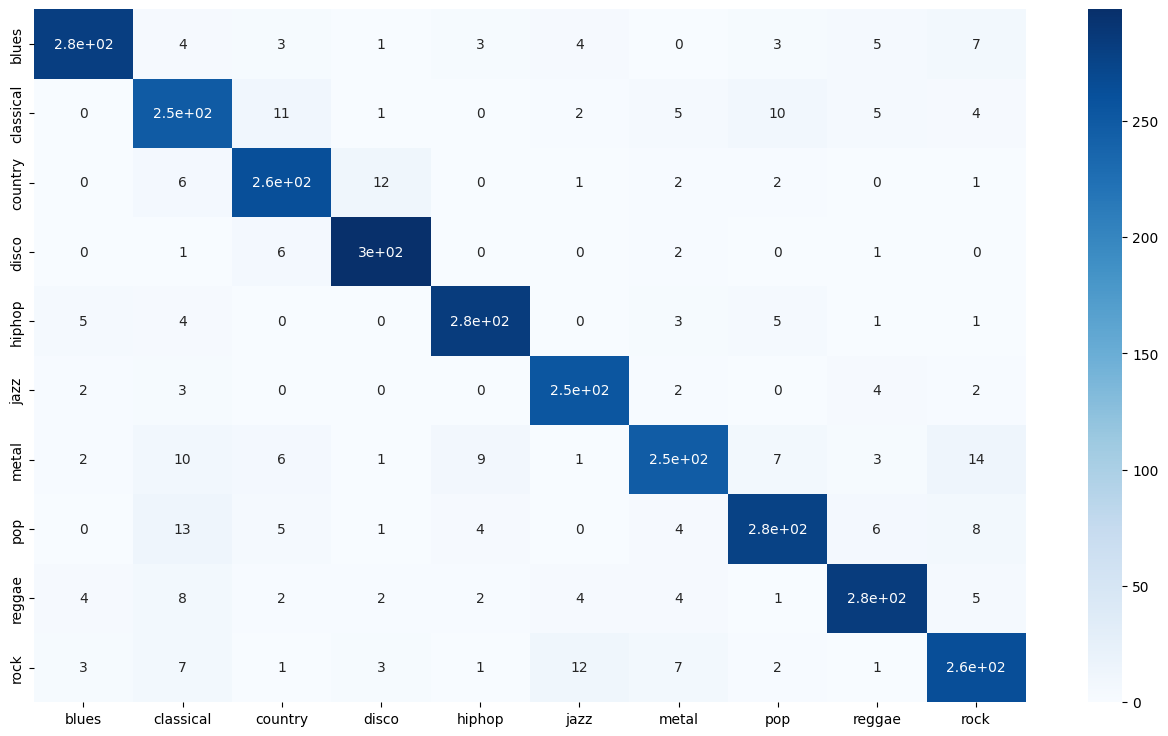

In [ ]:
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)


preds = xgb.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")

In [ ]:
columns = ['length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var']

In [111]:
file_name=[#'/content/drive/MyDrive/Colab_Notebooks/data/BMTH-HeavensSake-rock.wav',
          # '/content/drive/MyDrive/Colab_Notebooks/data/LittleTooLate-pop-noise.wav',
           #'/content/drive/MyDrive/Colab_Notebooks/data/LittleTooLate-pop-nonoise.wav',
           #'/content/drive/MyDrive/Colab_Notebooks/data/SweamingPools-KL-rap.wav',
           '/content/drive/MyDrive/Colab_Notebooks/data/animal_jazz.wav',
           #'/content/drive/MyDrive/Colab_Notebooks/data/maksim.wav', 
           '/content/drive/MyDrive/Colab_Notebooks/data/adele.wav',
           '/content/drive/MyDrive/Colab_Notebooks/data/imogean_heap.wav', 
           '/content/drive/MyDrive/Colab_Notebooks/data/akute.wav',
           #'/content/drive/MyDrive/Colab_Notebooks/data/pop/blues.wav',
           '/content/drive/MyDrive/Colab_Notebooks/data/travisscott.wav',
           '/content/drive/MyDrive/Colab_Notebooks/data/panics.wav',
           '/content/drive/MyDrive/Colab_Notebooks/data/lauv.wav',
           '/content/drive/MyDrive/Colab_Notebooks/data/linkinpark.wav',
           ]

In [ ]:
def compute_features(file):
    SAMPLE_RATE = 22050
    NUM_MFCC = 20
    N_FTT=2048
    HOP_LENGTH=512
    TRACK_DURATION = 15 # measured in seconds
    SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
    NUM_SEGMENTS = 10

    samples_per_segment = int(SAMPLES_PER_TRACK / NUM_SEGMENTS)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)

    signal, sr = librosa.load(file, sr=SAMPLE_RATE)
    signal, _ = librosa.effects.trim(signal)

    chroma_stft = librosa.feature.chroma_stft(y = signal, sr=sr, hop_length=HOP_LENGTH)

    rms = librosa.feature.rms(y = signal, hop_length=HOP_LENGTH)

    spectral_centroid = librosa.feature.spectral_centroid(y = signal, sr=sr, hop_length=HOP_LENGTH)

    spectral_bandwidth = librosa.feature.spectral_bandwidth(y = signal, sr=sr, hop_length=HOP_LENGTH)

    rolloff = librosa.feature.spectral_rolloff(y = signal, sr=sr, hop_length=HOP_LENGTH)

    zcr = librosa.feature.zero_crossing_rate(y = signal, frame_length=2048, hop_length=HOP_LENGTH)

    harmonic = librosa.effects.harmonic(y = signal)

    perceptr = librosa.perceptual_weighting(S = signal, frequencies=samples_per_segment)

    tempo = librosa.feature.tempo(y = signal, sr=sr, hop_length=HOP_LENGTH)

    mfcc = librosa.feature.mfcc(y = signal, sr=sr, hop_length=HOP_LENGTH)

    features={
        'length': samples_per_segment, 
        'chroma_stft_mean' : np.mean(chroma_stft), 
        'chroma_stft_var': np.var(chroma_stft), 
        'rms_mean': np.mean(rms), 
        'rms_var': np.var(rms),
        'spectral_centroid_mean': np.mean(spectral_centroid), 
        'spectral_centroid_var': np.var(spectral_centroid),
        'spectral_bandwidth_mean': np.mean(spectral_bandwidth),
        'spectral_bandwidth_var': np.var(spectral_bandwidth), 
        'rolloff_mean': np.mean(rolloff),
        'rolloff_var': np.var(rolloff), 
        'zero_crossing_rate_mean': np.mean(zcr), 
        'zero_crossing_rate_var': np.var(zcr),
        'harmony_mean': np.mean(harmonic), 
        'harmony_var': np.var(harmonic), 
        'perceptr_mean': np.mean(perceptr), 
        'perceptr_var': np.var(perceptr), 
        'tempo': np.mean(tempo[0]),
        'mfcc1_mean': np.mean(mfcc[0]), 
        'mfcc1_var': np.var(mfcc[0]), 
        'mfcc2_mean': np.mean(mfcc[1]), 
        'mfcc2_var': np.var(mfcc[1]), 
        'mfcc3_mean': np.mean(mfcc[2]),
        'mfcc3_var': np.var(mfcc[2]),
        'mfcc4_mean': np.mean(mfcc[3]), 
        'mfcc4_var': np.var(mfcc[3]),
        'mfcc5_mean': np.mean(mfcc[4]),
        'mfcc5_var': np.var(mfcc[4]),
        'mfcc6_mean': np.mean(mfcc[5]),
        'mfcc6_var': np.var(mfcc[5]),
        'mfcc7_mean': np.mean(mfcc[6]), 
        'mfcc7_var': np.var(mfcc[6]), 
        'mfcc8_mean': np.mean(mfcc[7]),
        'mfcc8_var': np.var(mfcc[7]), 
        'mfcc9_mean': np.mean(mfcc[8]), 
        'mfcc9_var': np.var(mfcc[8]), 
        'mfcc10_mean': np.mean(mfcc[9]), 
        'mfcc10_var': np.var(mfcc[9]),
        'mfcc11_mean': np.mean(mfcc[10]), 
        'mfcc11_var': np.var(mfcc[10]), 
        'mfcc12_mean': np.mean(mfcc[11]), 
        'mfcc12_var': np.var(mfcc[11]), 
        'mfcc13_mean': np.mean(mfcc[12]),
        'mfcc13_var': np.var(mfcc[12]),
        'mfcc14_mean': np.mean(mfcc[13]), 
        'mfcc14_var': np.var(mfcc[13]), 
        'mfcc15_mean': np.mean(mfcc[14]), 
        'mfcc15_var': np.var(mfcc[14]),
        'mfcc16_mean': np.mean(mfcc[15]),
        'mfcc16_var': np.var(mfcc[15]), 
        'mfcc17_mean': np.mean(mfcc[16]), 
        'mfcc17_var': np.var(mfcc[16]), 
        'mfcc18_mean': np.mean(mfcc[17]),
        'mfcc18_var': np.var(mfcc[17]), 
        'mfcc19_mean': np.mean(mfcc[18]), 
        'mfcc19_var': np.var(mfcc[18]), 
        'mfcc20_mean': np.mean(mfcc[19]), 
        'mfcc20_var': np.var(mfcc[19])
    }
   # print(features)
    df = pd.DataFrame(features, index=[0])

    return df



Find Similar Tracks

In [ ]:
import IPython.display as ipd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing


In [107]:
data_sim = pd.read_csv(f'{general_path}/features_30_sec.csv', index_col='filename')
def find_similar_songs(data, labels, name):


    # Find songs most similar to another song
    #df['label'] = ''
    
    #concat data
   # data = pd.DataFrame()
   # data = pd.concat([df, data_sim])

    # Extract labels
    #labels = data[['label']]

    # Drop labels from original dataframe
   # data = data.drop(columns=['length','label'])
    #data.head()

    # Scale the data
    #data_scaled=preprocessing.scale(data)
    #print('Scaled data type:', type(data_scaled))

    similarity = cosine_similarity(data)

    # Convert into a dataframe and then set the row index and column names as labels
    sim_df_labels = pd.DataFrame(similarity)
    sim_df_names = sim_df_labels.set_index(labels.index)
    sim_df_names.columns = labels.index

   # sim_df_names.head()
        
    series = sim_df_names[0].sort_values(ascending = False)
    
    # Remove cosine similarity == 1 (songs will always have the best match with themselves)
    series = series.drop(0)
    
    # Display the 5 top matches 
    print("\n*******\nSimilar songs to ", name)
    print(series.head(5))

In [ ]:
model_xgb = XGBClassifier()
model_xgb.load_model("Music_Genre_xgb.json")

In [112]:
data_sim = pd.read_csv(f'{general_path}/features_30_sec.csv', index_col='filename')
for f in file_name:
    print(f)
    new_input_mfcc = compute_features(f)
    print(new_input_mfcc.shape)

    # Find songs most similar to another song
    new_input_mfcc['label'] = ''
    
    #concat data
    data = pd.DataFrame()
    data = pd.concat([new_input_mfcc, data_sim])

    # Extract labels
    labels = data[['label']]

    X_to_predict = data.loc[:, data.columns != 'label']

    # Normalize so everything is on the same scale. 
    min_max_scaler = preprocessing.MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(X_to_predict)
    X_to_predict = pd.DataFrame(np_scaled, columns = columns)

    #prediction = model_xgb.predict(X_to_predict[X_to_predict.index==0])
    prediction = xgb.predict(X_to_predict[X_to_predict.index==0])

    find_similar_songs(X_to_predict, labels, f) 
    #predicted_index = np.argmax(prediction)
    print("Predicted Genre:", genre_dict[int(prediction)])

/content/drive/MyDrive/Colab_Notebooks/data/animal_jazz.wav
(1, 58)

*******
Similar songs to  /content/drive/MyDrive/Colab_Notebooks/data/animal_jazz.wav
pop.00076.wav        0.862955
country.00009.wav    0.862047
disco.00003.wav      0.861292
pop.00043.wav        0.860797
pop.00082.wav        0.860300
Name: 0, dtype: float64
Predicted Genre: pop
/content/drive/MyDrive/Colab_Notebooks/data/adele.wav
(1, 58)

*******
Similar songs to  /content/drive/MyDrive/Colab_Notebooks/data/adele.wav
country.00008.wav    0.864525
country.00000.wav    0.850402
pop.00043.wav        0.844581
disco.00063.wav      0.843525
reggae.00074.wav     0.840950
Name: 0, dtype: float64
Predicted Genre: pop
/content/drive/MyDrive/Colab_Notebooks/data/imogean_heap.wav
(1, 58)

*******
Similar songs to  /content/drive/MyDrive/Colab_Notebooks/data/imogean_heap.wav
country.00008.wav    0.830377
country.00000.wav    0.825714
pop.00043.wav        0.820901
country.00007.wav    0.820742
reggae.00073.wav     0.818955
Name: